In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.display import HTML, display
from sklearn.decomposition import PCA
from sklearn.metrics import jaccard_score
from tqdm.notebook import tqdm

np.random.seed(2622)

WINE_DATASET = dict(
    url='https://www.openml.org/data/get_csv/3624/dataset_191_wine.arff',
    class_column_name='class'
)

CARS_DATASET = dict(
    url='https://www.openml.org/data/get_csv/54/dataset_54_vehicle.arff',
    class_column_name='Class'
)


In [2]:
# noinspection PyTypeChecker
def show_dataframe(df: pd.DataFrame):
    display(HTML(df.to_html()))


In [3]:
def dataset(dataset_meta, verbose=False):
    df = pd.read_csv(dataset_meta['url'])
    if verbose:
        show_dataframe(df)
    X = df[df.columns.difference([dataset_meta['class_column_name']])]
    y, unique = pd.factorize(df[dataset_meta['class_column_name']])

    X = (X - X.min()) / (X.max() - X.min())
    return X.to_numpy(), y, len(unique)


def draw_plot(X_pca, classes, title='Clusters'):
    xx, yy = X_pca.T
    plt.figure(figsize=(10, 10))
    plt.scatter(xx, yy, c=classes, alpha=0.9, cmap=plt.cm.get_cmap('tab10', len(set(classes))))
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()


In [4]:
np.random.rand(3)


array([0.22951031, 0.8058174 , 0.96121335])

In [5]:

def distance(x1, x2):
    return np.linalg.norm(x1 - x2)


class KMeans:
    def __init__(self, clusters, epochs_max=200):
        self.clusters = clusters
        self.epochs_max = epochs_max
        self.centroids = None

    def closestCentroidInd(self, point):
        return int(np.argmin(list(map(lambda x: distance(x, point), self.centroids))))

    def findCentroids(self, X):
        self.centroids = [X[np.random.randint(len(X))]]
        for _ in range(self.clusters - 1):
            distances = [
                distance(point, self.centroids[self.closestCentroidInd(point)]) for point in X
            ]

            distsSum = np.sum(distances)

            randSum = np.random.random() * distsSum

            curIdx = 0
            curSum = distances[0]

            while curSum < randSum:
                curIdx += 1
                curSum += distances[curIdx]
            self.centroids.append(X[curIdx])

    def fit(self, X):
        self.findCentroids(X)

        for _ in range(self.epochs_max):
            clusters = [[] for _ in range(self.clusters)]
            for point in X:
                closestCentroid = self.closestCentroidInd(point)
                clusters[closestCentroid].append(point)

            newCentroids = [np.mean(clusters[i], axis=0) for i in range(self.clusters)]

            if np.allclose(self.centroids, newCentroids):
                break

            self.centroids = newCentroids

    def predict(self, X):
        return np.apply_along_axis(self.closestCentroidInd, 1, X)


In [6]:

def dunn_score(X, y):
    labelsCount = len(np.unique(y))

    max_dist = -np.inf
    for i in range(labelsCount):
        points = X[y == i]
        for j, p1 in enumerate(points):
            for p2 in points[j:]:
                max_dist = max(max_dist, distance(p1, p2))

    min_dist = np.inf  # outer
    for i, c1 in enumerate(y):
        for j, c2 in enumerate(y):
            if c1 != c2:
                min_dist = min(min_dist, distance(X[i], X[j]))

    return min_dist / max_dist


def scores(X, y, max_clusters=20):
    metrics = dict(
        jaccard=lambda _y_pred: jaccard_score(y_true=y, y_pred=_y_pred, average='macro'),
        dunn=lambda _y_pred: dunn_score(X, _y_pred)
    )

    metered_clusters = list(range(2, max_clusters + 1))

    metrics_result = {}

    for name in metrics.keys():
        metrics_result[name] = []

    for clusters in tqdm(metered_clusters):
        kMeans = KMeans(clusters=clusters)

        kMeans.fit(X)
        y_pred = kMeans.predict(X)

        for name, func in metrics.items():
            metrics_result[name].append(func(y_pred))

    plt.figure(figsize=(10, 10))
    plt.title('Metrics')

    for name, yy in metrics_result.items():
        plt.plot(metered_clusters, yy, label=name)
    plt.legend()
    plt.show()


In [7]:
def process(dataset_meta, verbose_level=0):
    X, y, classes_cnt = dataset(dataset_meta, verbose_level >= 2)

    if verbose_level >= 1:
        print(f"Got {len(y)} samples with {classes_cnt} classes. Features count: {X.shape[1]}")

    X_pca = PCA(n_components=2).fit_transform(X)
    draw_plot(X_pca, y, title='Real labels')

    kMeans = KMeans(classes_cnt)
    kMeans.fit(X)
    pred = kMeans.predict(X)

    draw_plot(X_pca, pred, title='K-Means labels')

    scores(X, y, max_clusters=10)


Got 178 samples with 3 classes. Features count: 13


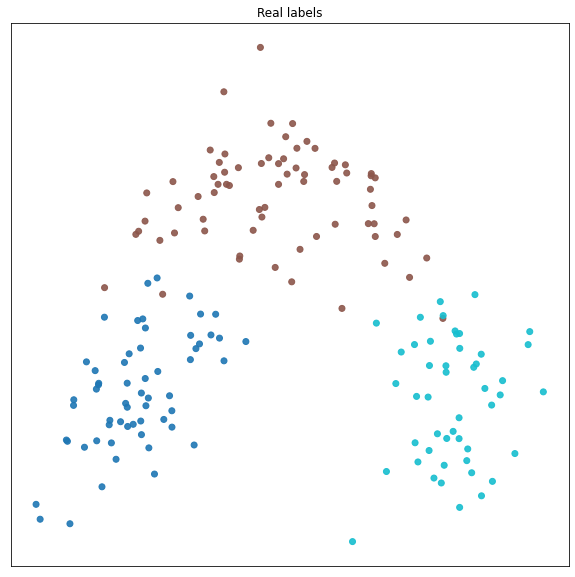

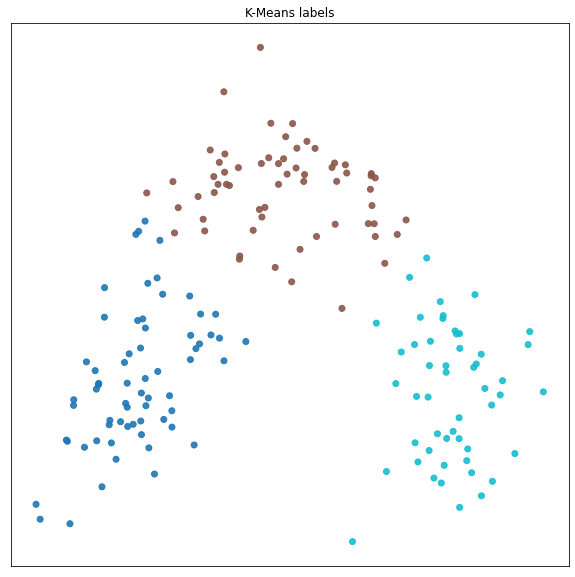

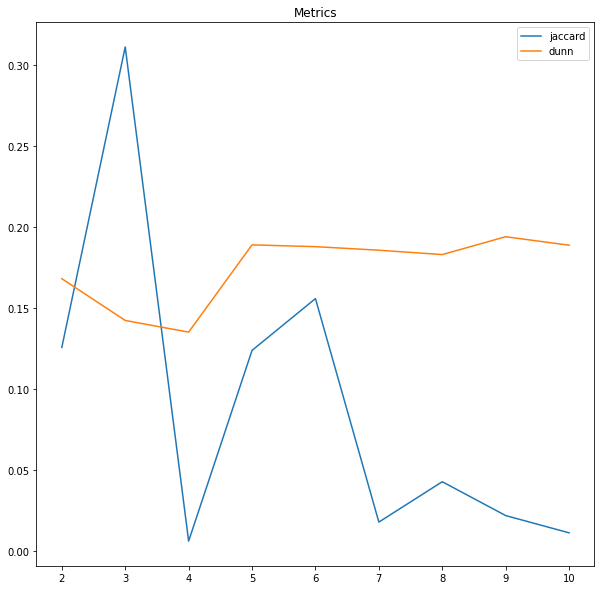

In [8]:
process(WINE_DATASET, verbose_level=1)